# Eksploratorna analiza podataka

Podatke za ovaj projekt cemo prikupiti koristenjem Spotify API i Python biblioteke spotipy. 

In [ ]:
pip install spotipy

Koristeci Spotify for Developers Dashboard, obicni korisnik Spotifyja moze pristupiti Spotify API-ju i povezati svoje aplikacije s njime putem dobivenog CLIENT_ID i CLIENT_SECRET. Ovime se moze pristupiti raznim informacijama o pjesmama na Spotifyju, ali i personaliziranim, osobnim informacijama tog korisnika.

In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

CLIENT_ID = '?'
CLIENT_SECRET = "?"

CLIENT_CREDENTIALS_MANAGER = SpotifyClientCredentials(
    client_id=CLIENT_ID, client_secret=CLIENT_SECRET
)
SP = spotipy.Spotify(client_credentials_manager=CLIENT_CREDENTIALS_MANAGER)


Za potrebe naseg projekta, zelimo koristenjem linkova na neku playlistu prikupiti informacije o pjesmama u tim playlistama. Za prvu ruku, prikupljamo informaciju o imenu pjesme i izvodjaca, te metadata audio_features informacije. 

In [6]:
def get_playlist_uri(playlist_link):
    return playlist_link.split("/")[-1].split("?")[0]

def get_track_data(playlist_link):
    playlist_uri = get_playlist_uri(playlist_link)
    results = SP.playlist_tracks(playlist_uri)
    playlist_tracks = results["items"]

    while results["next"]:
        results = SP.next(results)
        playlist_tracks.extend(results["items"])

    track_data = []
    for track in playlist_tracks:
        if not "track" in track or not track["track"]:
            continue
        
        track_uri = track["track"]["uri"]
        track_name = track["track"]["name"]
        artist = track["track"]["artists"]

        data = {
            "name": track_name,
            "data": SP.audio_features(track_uri),
            "artist": artist
        }
        track_data.append(data)

    return track_data

Pogledajmo koje povratne informacije dobijemo pozivom gornje funkcije za neku playlistu, 

In [7]:
playlist = "https://open.spotify.com/playlist/4LE68Dhe9dW3792v4TOg3T"
playlist_data = get_track_data(playlist)
print(playlist_data)

[{'name': 'Getaway Car', 'data': [{'danceability': 0.562, 'energy': 0.689, 'key': 2, 'loudness': -6.745, 'mode': 1, 'speechiness': 0.127, 'acousticness': 0.00465, 'instrumentalness': 2.23e-06, 'liveness': 0.0888, 'valence': 0.351, 'tempo': 172.054, 'type': 'audio_features', 'id': '0VE4kBnHJUgtMf0dy6DRmW', 'uri': 'spotify:track:0VE4kBnHJUgtMf0dy6DRmW', 'track_href': 'https://api.spotify.com/v1/tracks/0VE4kBnHJUgtMf0dy6DRmW', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0VE4kBnHJUgtMf0dy6DRmW', 'duration_ms': 233627, 'time_signature': 4}], 'artist': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/06HL4z0CvFAxyc27GXpf02'}, 'href': 'https://api.spotify.com/v1/artists/06HL4z0CvFAxyc27GXpf02', 'id': '06HL4z0CvFAxyc27GXpf02', 'name': 'Taylor Swift', 'type': 'artist', 'uri': 'spotify:artist:06HL4z0CvFAxyc27GXpf02'}]}, {'name': 'Delicate', 'data': [{'danceability': 0.75, 'energy': 0.404, 'key': 9, 'loudness': -10.178, 'mode': 0, 'speechiness': 0.0682, 'acousticness

Za potrebe projekta, najbitnije ce nam biti informacije o zvucnom zapisu pjesme. Pogledajmo na primjeru jedne pjesme koje sve informacije mozemo izvuci o njezinom zvucnom zapisu - te informacije ce nam biti kljucni atributi za treniranje modela. 

In [9]:
data = {"name": playlist_data[0]["name"]}
data.update(playlist_data[0]["data"][0])
df = pd.DataFrame.from_dict(data, orient='index', columns = ['data'])
df

,data
name,Getaway Car
danceability,0.562
energy,0.689
key,2
loudness,-6.745
mode,1
speechiness,0.127
acousticness,0.00465
instrumentalness,0.000002
liveness,0.0888


Kao sto smo naveli i argumentirali u projektnom prijedlogu, razvijat cemo dva modela - posebno za instrumentalnu i vokalnu glazbu. Promotrimo prvo dataset za vokalnu glazbu. Za stvaranje dataseta, na Spotifyu smo pretrazili playliste koje svojim nazivom odgovaraju kategorijama happy/sad/energetic/calm. Pri tome smo pazili da ne koristimo playliste koje bi mogle pokrivati vise od jedne kategorije, primjerice: happy energetic music, ili sad calm music. Takodjer je bitno da playliste nisu tematski motivirane u nekom drugom smjeru.  Odabrane playliste imaju vise desetaka tisuca lajkova, pa mozemo zakljuciti da se velik broj slusatelja slaze s njihovim kategorizacijama.

In [10]:
PLAYLISTS_VOCAL = {
    "happy": [
        "https://open.spotify.com/playlist/0RH319xCjeU8VyTSqCF6M4",
        "https://open.spotify.com/playlist/0gSCSc9k468XnIRxfnbLSb",
        "https://open.spotify.com/playlist/7s09coXLGbofhNrwSusr4G",
        "https://open.spotify.com/playlist/1h90L3LP8kAJ7KGjCV2Xfd",
        "https://open.spotify.com/playlist/7vBShQfXqgKHshNTD9JnWQ",
        "https://open.spotify.com/playlist/5Bb191DNPuoQSUze6Ta4gU",
        "https://open.spotify.com/playlist/5XcdFPX9Q70Fg9cMrhTYGD",
        "https://open.spotify.com/playlist/47zZl5XOX2bkbEwJj1dOXi",
        "https://open.spotify.com/playlist/7a8xfvogHnGzZKQUenPCms",
        "https://open.spotify.com/playlist/0kWycnqEfYA31P87pJBtA8"
    ],
    "sad": [
        "https://open.spotify.com/playlist/4WSPfsbXWNicaHAREY7mc7",
        "https://open.spotify.com/playlist/4yXfnhz0BReoVfwwYRtPBm",
        "https://open.spotify.com/playlist/5qos0qiVoklN1fcGH6Pn2I",
        "https://open.spotify.com/playlist/3bLn8QacvZhZtnXDHztJVu",
        "https://open.spotify.com/playlist/6nxPNnmSE0d5WlplUsa5L3",
        "https://open.spotify.com/playlist/54NczufWOFmJ5jUVvRPxaF",
        "https://open.spotify.com/playlist/53NEfJTEt86ytgk5SaqMjZ",
        "https://open.spotify.com/playlist/37i9dQZF1DX7qK8ma5wgG1",
        "https://open.spotify.com/playlist/3VUZgyetVrL32whyhsmcCf",
        "https://open.spotify.com/playlist/6YP0LBSW69XAbZy8VPTdFB"
    ],
    "energetic": [
        "https://open.spotify.com/playlist/2lmcuXNkjYOoQeXvwqvvFT",
        "https://open.spotify.com/playlist/5usLXHq0ZrH37KkBG4xHTN",
        "https://open.spotify.com/playlist/7o0F1zBcjGD2GtqfAO23qk",
        "https://open.spotify.com/playlist/3FbgPTcaVAQ1qeJU0okzlP",
        "https://open.spotify.com/playlist/6nRNEBYokMy5gzOVgly8TF",
        "https://open.spotify.com/playlist/6m7EO9jNGDMNi4T1ABlzT6",
        "https://open.spotify.com/playlist/3mJqaVcHbGu93JoGw4q0HX",
        "https://open.spotify.com/playlist/4iKsk3h7tx6Qxqg0xmaHZi",
        "https://open.spotify.com/playlist/2yVmk8YFndKeMteFSMl69A",
        "https://open.spotify.com/playlist/6iMsb2DtRKUpDoEbKxA443",
        "https://open.spotify.com/playlist/3F6KJ8qEGW2khXgnDkRf6h",
        "https://open.spotify.com/playlist/0YUScJ2xJRsppiwFEoBbNa"
    ],
    "calm": [
        "https://open.spotify.com/playlist/1q4ImomvloMKAmkMkmMRVp",
        "https://open.spotify.com/playlist/11q1sTpWABVhGmIBcfDLtt",
        "https://open.spotify.com/playlist/13TUMlrE3NDGBn0Admi2Nd",
        "https://open.spotify.com/playlist/37h67cBZqNcxNXFcp3VGe8",
        "https://open.spotify.com/playlist/25EE0kXWncLfPvhkycQ4hR",
        "https://open.spotify.com/playlist/55UMZVJqlPIf6eAaNULfu7",
        "https://open.spotify.com/playlist/6NDj3ND1LX4molWlkRXYFA",
        "https://open.spotify.com/playlist/2lvsH4hZU77uOaPilrDttK",
        "https://open.spotify.com/playlist/6qEHPAsLKrURmkk1TxJYpI",
        "https://open.spotify.com/playlist/0nINy1bfIZYU6nrHKKXbBV"
    ]
}


Za svaku playlistu sada mozemo prikupiti prethodno prikazane informacije:

In [52]:
tracks_data = {
    "happy": [],
    "sad": [],
    "energetic": [],
    "calm": []
}

for label in PLAYLISTS_VOCAL.keys():
    for playlist_link in PLAYLISTS_VOCAL[label]:
        print(label, playlist_link)
        track_data = get_track_data(playlist_link)
        tracks_data[label] += track_data

happy https://open.spotify.com/playlist/0RH319xCjeU8VyTSqCF6M4
happy https://open.spotify.com/playlist/0gSCSc9k468XnIRxfnbLSb
happy https://open.spotify.com/playlist/7s09coXLGbofhNrwSusr4G
happy https://open.spotify.com/playlist/1h90L3LP8kAJ7KGjCV2Xfd
happy https://open.spotify.com/playlist/7vBShQfXqgKHshNTD9JnWQ
happy https://open.spotify.com/playlist/5Bb191DNPuoQSUze6Ta4gU
happy https://open.spotify.com/playlist/5XcdFPX9Q70Fg9cMrhTYGD
happy https://open.spotify.com/playlist/47zZl5XOX2bkbEwJj1dOXi
happy https://open.spotify.com/playlist/7a8xfvogHnGzZKQUenPCms
happy https://open.spotify.com/playlist/0kWycnqEfYA31P87pJBtA8
sad https://open.spotify.com/playlist/4WSPfsbXWNicaHAREY7mc7
sad https://open.spotify.com/playlist/4yXfnhz0BReoVfwwYRtPBm
sad https://open.spotify.com/playlist/5qos0qiVoklN1fcGH6Pn2I
sad https://open.spotify.com/playlist/3bLn8QacvZhZtnXDHztJVu
sad https://open.spotify.com/playlist/6nxPNnmSE0d5WlplUsa5L3
sad https://open.spotify.com/playlist/54NczufWOFmJ5jUVvRPxaF
sad 

Pogledajmo koliko imamo pjesama za svaku kategoriju:

In [53]:
df = pd.DataFrame.from_dict({key: len(tracks_data[key]) for key in tracks_data.keys()}, orient = 'index', columns = ['number of songs'])
df

,number of songs
happy,1629
sad,1538
energetic,1590
calm,1683


Vidimo da smo dobili vise od 1500 pjesama po kategorijama. No, to ne znaci nuzno da u svakoj kategoriji imamo toliko pjesama, jer je moguce da se unutar neke kategorije, npr. "happy", neka pjesma nalazi u vise playlisti. Za pocetak trebamo ocistiti duplikate u playlistama istih kategorija.

In [54]:
label_data_unique = {
    "happy": [],
    "sad": [],
    "energetic": [],
    "calm": []
}

for label in label_data_unique.keys():
    for track_data in tracks_data[label]:
        if not track_data in label_data_unique[label]:
            label_data_unique[label].append(track_data)
            
df = pd.DataFrame.from_dict({key: len(label_data_unique[key]) for key in label_data_unique.keys()}, orient = 'index', columns = ['number of songs'])
df           

,number of songs
happy,1363
sad,1062
energetic,1494
calm,1519


Nadalje, mozemo ocekivati da postoje preklapanja pjesama koje su svrstane u vise kategorija. Primjerice, neka pjesma istovremeno moze biti kategorizirana i kao "happy" i kao "energetic", ili moze biti kategorizirana i kao "sad" i kao "calm". Za takve pjesme nemamo dovoljno snazan signal kojim bismo ih svrstali u samo jednu kategoriju, stoga cemo maknuti takve pjesme te zadrzati samo one koje su svrstane u samo jednu kategoriju.

In [55]:
all_tracks = []
for label in label_data_unique.keys():
    all_tracks += label_data_unique[label]

song_data_unique = {
    "happy": [],
    "sad": [],
    "energetic": [],
    "calm": []  
}

for label in label_data_unique.keys():
    for label_data in label_data_unique[label]:
        if all_tracks.count(label_data) == 1:
            song_data_unique[label].append(label_data)
            
df = pd.DataFrame.from_dict({key: len(song_data_unique[key]) for key in song_data_unique.keys()}, orient = 'index', columns = ['number of songs'])
df           

,number of songs
happy,1101
sad,766
energetic,1241
calm,1130


Nije potrebno provjeravati daljnju jedinstvenost pjesama, jer Spotify sam vodi racuna o reuploadima i kopijama pjesama. S obzirom na velik broj pjesama, zelimo da one budu dobro balansirane u odnosu na neke kriterije. Primjerice, ne bi bilo dobro da vecina pjesama dolazi od nekog malog broja izvodjaca. Promotrimo broj izvodjaca po kategorijama i broj pojavljivanja 20 najcescih izvodjaca.

,number of different artists
happy,675
sad,501
energetic,634
calm,647


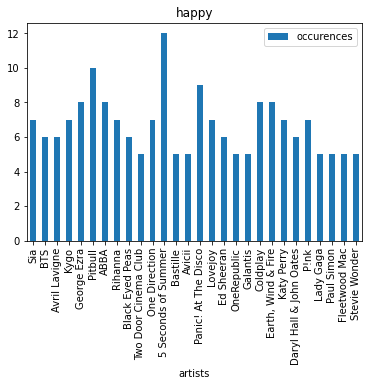

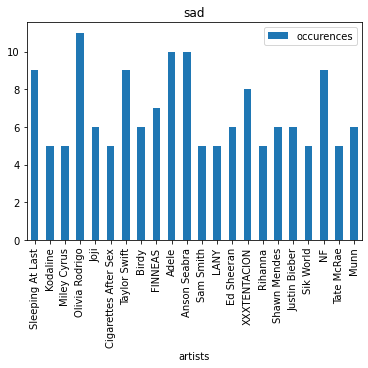

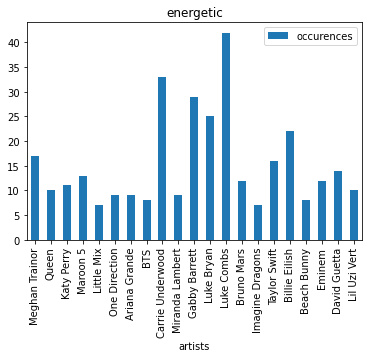

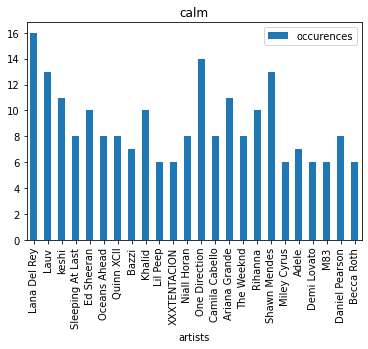

In [56]:
def show_common_artists(song_data, label, n):
    artist_cnt = {}
    for song in song_data:
        artist = song["artist"][0]["name"]
        if artist in artist_cnt:
            artist_cnt[artist] += 1
        else:
            artist_cnt[artist] = 1
            
    cnt = list(artist_cnt.values())
    cnt.sort()
    top_n_val = cnt[-n]
    
    artists = [a for a in artist_cnt.keys() if artist_cnt[a] >= top_n_val]
    cnt = [artist_cnt[a] for a in artist_cnt.keys() if artist_cnt[a] >= top_n_val]
    df = pd.DataFrame(data = {"artists": artists, "occurences": cnt})
    df.plot.bar(x = "artists", y = "occurences", rot = 90, title = label)
    
    return len(artist_cnt.keys())
            
num_diff_artists = {
    "happy": 0,
    "sad": 0,
    "energetic": 0,
    "calm": 0
}

for label in num_diff_artists.keys():
    cnt = show_common_artists(song_data_unique[label], label, 20)
    num_diff_artists[label] = cnt
    
df = pd.DataFrame.from_dict(num_diff_artists, orient = 'index', columns = ['number of different artists'])
df

Kod vokalne glazbe je ocekivano da traje oko 3 minute. Stoga ocekujemo da ce to vrijediti i za ovaj dataset, tj. da ce vecina pjesama imati trajanje oko 3 minute uz manji broj outliera. 

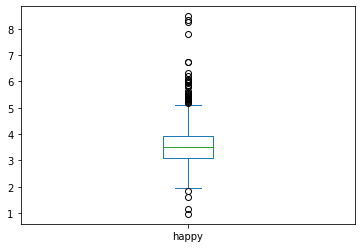

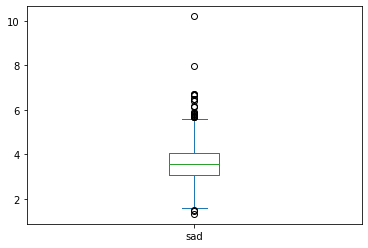

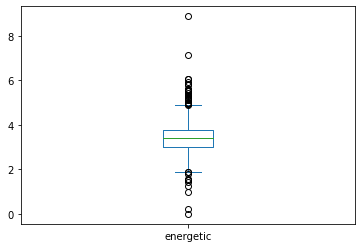

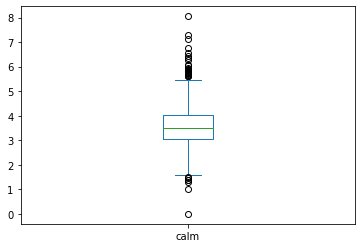

In [57]:
durations = {
    "happy": [],
    "sad": [],
    "energetic": [0],
    "calm": [0]
}

for label in song_data_unique.keys():
    for track in song_data_unique[label]:
        durations[label].append(track["data"][0]["duration_ms"] / 60000.0)

for label in durations:
    df = pd.DataFrame(durations[label], columns = [label])
    df.plot.box()    
        

S obzirom na to da ce nam informacije o zvucnom zapisu biti kljucni atributi kod treniranja modela, promotrimo vrijednosti njihovih medijana po kategorijama. 

In [58]:
features = ["danceability", "acousticness", "energy", "instrumentalness", "liveness","valence", "loudness", "speechiness", "tempo"]

mean_vals = []

for label in song_data_unique.keys():
    stats = {}
    vals = []
    for feature in features:
        stats[feature] = []
    for song in song_data_unique[label]:
        for feature in stats.keys():
            stats[feature].append(song["data"][0][feature])
    for feature in features:
        s = stats[feature]
        s.sort()
        half = int(len(s) / 2)
        vals.append(s[half])
    mean_vals += [vals]

df = pd.DataFrame(mean_vals, columns = features, index = song_data_unique.keys())
df

,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo
happy,0.662,0.0599,0.778,0.000002,0.133,0.667,-5.576,0.0496,120.050
sad,0.543,0.6400,0.392,0.000004,0.112,0.258,-8.771,0.0396,116.714
energetic,0.655,0.0664,0.761,0.000000,0.124,0.563,-5.187,0.0582,120.957
calm,0.565,0.4160,0.482,0.000003,0.113,0.331,-7.616,0.0400,114.578


Mozemo kratko interpretirati neke od atributa koji su nam intuitivno jasni. Primjerice, vrijednost atributa 'energy' je vrlo visoka kod pjesma kategoriziranih kao 'happy' i 'energetic', a prilicno niska kod pjesama kategoriziranih kao 'sad' i 'calm'. Vrijednosti atributa 'danceability' su vise kod 'happy' i 'energetic' pjesama nego kod 'sad' i 'calm', kao sto bismo i ocekivali. Za interpretaciju ostalih atributa cemo morati bolje prouciti sto oni predstavljaju kod Spotifya i u teoriji glazbe opcenito. Primijetimo da vrijednosti nisu normalizirane - u sljedecoj fazi projekta cemo prouciti unutar kojih intervala se poprimaju vrijednosti, sto one predstavljaju u teoriji glazbe i koji su najbolji nacini za normalizaciju. Za prvu ruku, mozemo ih normalizirati koristeci MinMaxScaler() kako bismo ih mogli graficki prikazati. 

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mean_vals)
mean_vals = scaler.transform(mean_vals)
print(mean_vals)

[[1.         0.         1.         0.50675676 1.         1.
  0.89146205 0.53763441 0.8578147 ]
 [0.         1.         0.         1.         0.         0.
  0.         0.         0.33484872]
 [0.94117647 0.01120496 0.95595855 0.         0.57142857 0.74572127
  1.         1.         1.        ]
 [0.18487395 0.61385968 0.23316062 0.68243243 0.04761905 0.17848411
  0.32226563 0.02150538 0.        ]]


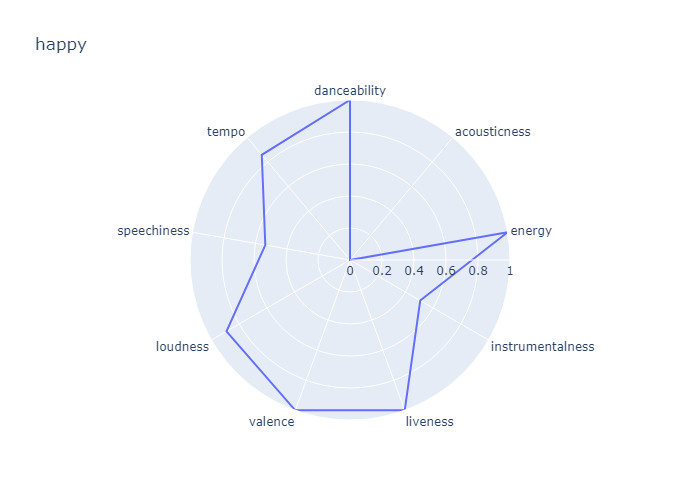

In [61]:
import plotly.express as px
from IPython.display import Image


df = pd.DataFrame({"values":mean_vals[0],"Name": features})
fig = px.line_polar(df, r="values", theta='Name', line_close=True, title = "happy")
img_bytes = fig.to_image(format="png")

Image(img_bytes)


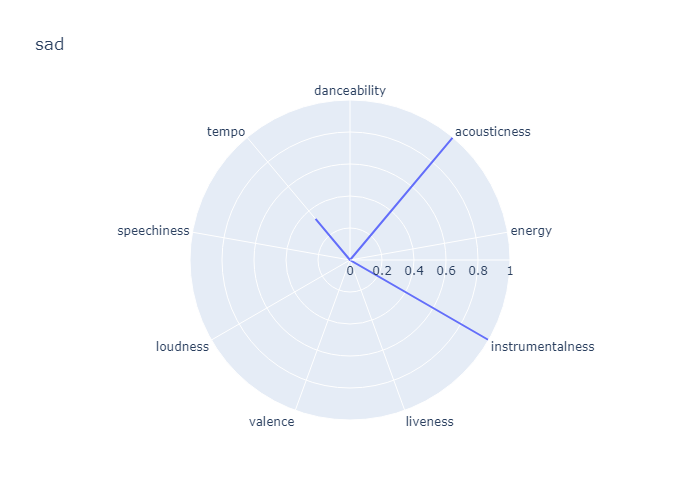

In [62]:
df = pd.DataFrame({"values":mean_vals[1],"Name": features})
fig = px.line_polar(df, r="values", theta='Name', line_close=True, title = "sad")
img_bytes = fig.to_image(format="png")

Image(img_bytes)

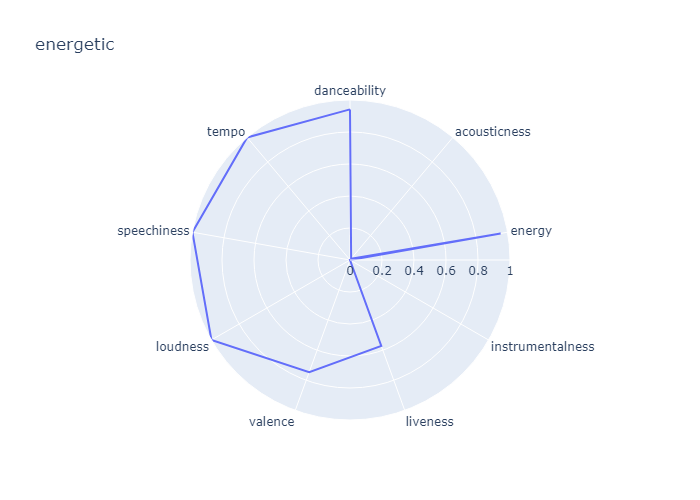

In [63]:
df = pd.DataFrame({"values":mean_vals[2],"Name": features})
fig = px.line_polar(df, r="values", theta='Name', line_close=True, title = "energetic")
img_bytes = fig.to_image(format="png")

Image(img_bytes)

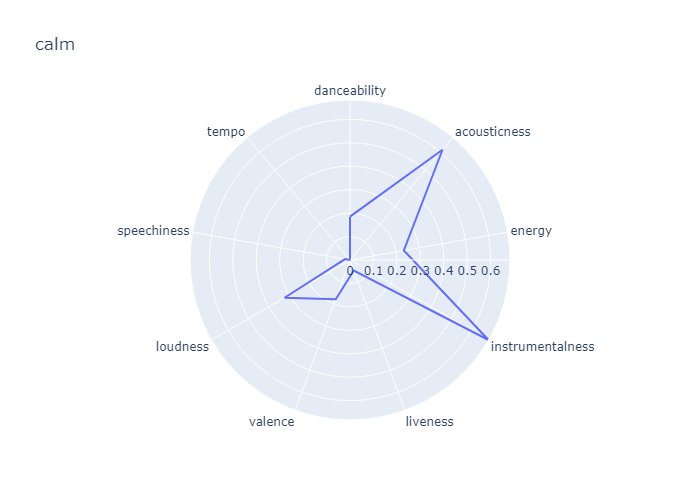

In [64]:
df = pd.DataFrame({"values":mean_vals[3],"Name": features})
fig = px.line_polar(df, r="values", theta='Name', line_close=True, title = "calm")
img_bytes = fig.to_image(format="png")

Image(img_bytes)

Isti postupak cemo sada provesti i za instrumentalne pjesme! Kao i kod vokalnih, prikupili smo dovoljan broj razlicitih playlisti sa Spotifyja za svaku od kategorija.

In [65]:
PLAYLISTS_INSTRUMENTAL = {
    "happy": [
        "https://open.spotify.com/playlist/37i9dQZF1DX5YTAi6JhwZm",
        "https://open.spotify.com/playlist/41TjplTM10Xkz8NQM4Gxgz",
        "https://open.spotify.com/playlist/57CfuwaT1ERCKrJIcTPL4M",
        "https://open.spotify.com/playlist/37i9dQZF1EIfH1txuVhls0",
        "https://open.spotify.com/playlist/67wR3uJ9IZbcGxr75tWGox",
        "https://open.spotify.com/playlist/7CR8qhrUZI4xP6Jfb2crF7",
        "https://open.spotify.com/playlist/2JLiBjIZ3hEdtmzR7ddj3t",
        "https://open.spotify.com/playlist/37i9dQZF1DX5Lm1ZiObdc3",
        "https://open.spotify.com/playlist/2mu4kG7W1LVjDh8SsxZBLF",
        "https://open.spotify.com/playlist/52mOSwZguzpe6g4gi1OAiz",
        "https://open.spotify.com/playlist/4lZmrL1rR70ByIttwlyg3T",
        "https://open.spotify.com/playlist/30otsp3wAOIUeovU3ujCIt",
        "https://open.spotify.com/playlist/37i9dQZF1EIfC7Q0wzXcSs",
        "https://open.spotify.com/playlist/5vpbN3iPV226kgWM6ennF5",
        "https://open.spotify.com/playlist/2OzQaoF47GjvA8xTQnCdmF",
        "https://open.spotify.com/playlist/37i9dQZF1EIecNEvofO0cv",
        "https://open.spotify.com/playlist/5EZe2uLOPlcP8BwipJnX4m",
        "https://open.spotify.com/playlist/6QjrzhtDINMmn9zRG0GoT4",
        "https://open.spotify.com/playlist/5Iq05hg7E2871FUUfqx5Tj",
        "https://open.spotify.com/playlist/7kgrJ5gKq0KjiPZFQ2Hzru"

    ],
    "sad": [
        "https://open.spotify.com/playlist/37i9dQZF1DXbm0dp7JzNeL",
        "https://open.spotify.com/playlist/66SFSB5zjo72Op9CmLOP6J",
        "https://open.spotify.com/playlist/3tzZNGemkwbXFH6T6r4ElA",
        "https://open.spotify.com/playlist/6EuuZSNU783jt5OR4ab9gm",
        "https://open.spotify.com/playlist/37i9dQZF1EIho7aAvepWLq",
        "https://open.spotify.com/playlist/5sQwSji84eb9wk4ekFe8BU",
        "https://open.spotify.com/playlist/3ZPVhKwU8uDm9n5V3j31B6",
        "https://open.spotify.com/playlist/0E9h5M132FO2dBO0nIsoQQ",
        "https://open.spotify.com/playlist/1ZNyfavZ6E4Zp9hRYEW5hN",
        "https://open.spotify.com/playlist/4lAmlZTxQ93NI8TzvDhcSe",
        "https://open.spotify.com/playlist/4mC5iVoSTFk6lfvTOQNGJS",
        "https://open.spotify.com/playlist/4ZvXndZcjzeNTiQQktGRQ5",
        "https://open.spotify.com/playlist/7eBOMC4lOeQKc9tTU7n4r1"
    ],
    "energetic": [
        "https://open.spotify.com/playlist/3zHcsPgAzDWsHnhXUePUzk",
        "https://open.spotify.com/playlist/4fp9VDerh0IcDIiDeqaze8",
        "https://open.spotify.com/playlist/5oZrLBSoKbNks0pkumBPAC",
        "https://open.spotify.com/playlist/1MEzRaskHQ33yfpIJi937s",
        "https://open.spotify.com/playlist/6Ln2k4ap6vnYnsnFIgWVIQ",
        "https://open.spotify.com/playlist/0wZkkt5WwFqBCO6v5mUwRX",
        "https://open.spotify.com/playlist/5JDYOk2m5R6iZVECboNnRX",
        "https://open.spotify.com/playlist/37JieBsBWZPOncS5Ax03gW",
        "https://open.spotify.com/playlist/5yGImKk65jmwpMpTe6Dmcz",
        "https://open.spotify.com/playlist/2okPaleCQ0B6uK6Yp0fxEM",
        "https://open.spotify.com/playlist/38PoCVRTELMdLWdsSGPSYd"
    ],
    "calm": [
        "https://open.spotify.com/playlist/37i9dQZF1DWVFeEut75IAL",
        "https://open.spotify.com/playlist/37i9dQZF1EIhafNyt5FfZM",
        "https://open.spotify.com/playlist/3hLFilSnwA3LGq81mJXYFg",
        "https://open.spotify.com/playlist/7cLOoKbAe6iYGo7L4XzrW3",
        "https://open.spotify.com/playlist/7evkoMvV54UfMp4xzZ8Xs5",
        "https://open.spotify.com/playlist/7tSKRdZX36sLhoPic8PXMP",
        "https://open.spotify.com/playlist/3Yn1YauCcpJTnDfipB1HRb",
        "https://open.spotify.com/playlist/5gaVqhrTrbBigae3ZAZfbq",
        "https://open.spotify.com/playlist/6gBBwRrXPiwXFSUHjvIQPL",
        "https://open.spotify.com/playlist/5ZEQJAi8ILoLT9OlSxjtE7",
        "https://open.spotify.com/playlist/5xFWldtMdj7WarnQmGUMtw",
        "https://open.spotify.com/playlist/1l3Trl4w5ZwlsMyvNCtjHk"
    ]
}

In [26]:
tracks_data = {
    "happy": [],
    "sad": [],
    "energetic": [],
    "calm": []
}

for label in PLAYLISTS_INSTRUMENTAL.keys():
    for playlist_link in PLAYLISTS_INSTRUMENTAL[label]:
        print(label, playlist_link)
        track_data = get_track_data(playlist_link)
        tracks_data[label] += track_data


happy https://open.spotify.com/playlist/37i9dQZF1DX5YTAi6JhwZm
happy https://open.spotify.com/playlist/41TjplTM10Xkz8NQM4Gxgz
happy https://open.spotify.com/playlist/57CfuwaT1ERCKrJIcTPL4M
happy https://open.spotify.com/playlist/37i9dQZF1EIfH1txuVhls0
happy https://open.spotify.com/playlist/67wR3uJ9IZbcGxr75tWGox
happy https://open.spotify.com/playlist/7CR8qhrUZI4xP6Jfb2crF7
happy https://open.spotify.com/playlist/2JLiBjIZ3hEdtmzR7ddj3t
happy https://open.spotify.com/playlist/37i9dQZF1DX5Lm1ZiObdc3
happy https://open.spotify.com/playlist/2mu4kG7W1LVjDh8SsxZBLF
happy https://open.spotify.com/playlist/52mOSwZguzpe6g4gi1OAiz
happy https://open.spotify.com/playlist/4lZmrL1rR70ByIttwlyg3T
happy https://open.spotify.com/playlist/30otsp3wAOIUeovU3ujCIt
happy https://open.spotify.com/playlist/37i9dQZF1EIfC7Q0wzXcSs
happy https://open.spotify.com/playlist/5vpbN3iPV226kgWM6ennF5
happy https://open.spotify.com/playlist/2OzQaoF47GjvA8xTQnCdmF
happy https://open.spotify.com/playlist/37i9dQZF1EIecNE

Pogledajmo koliko imamo pjesama po kategoriji:

In [27]:
df = pd.DataFrame.from_dict({key: len(tracks_data[key]) for key in tracks_data.keys()}, orient = 'index', columns = ['number of songs'])
df

,number of songs
happy,1259
sad,1034
energetic,1711
calm,1073


Kao i prije, procistit cemo pjesme tako da osiguramo da nemamo dupliciranje pjesama i da nemamo pjesme koje se mogu svrstati u vise od jedne kategorije. Za pocetak, osiguravamo jedinstvenost pjesama po kategoriji:

In [28]:
label_data_unique = {
    "happy": [],
    "sad": [],
    "energetic": [],
    "calm": []
}

for label in label_data_unique.keys():
    for track_data in tracks_data[label]:
        if not track_data in label_data_unique[label]:
            label_data_unique[label].append(track_data)
            
df = pd.DataFrame.from_dict({key: len(label_data_unique[key]) for key in label_data_unique.keys()}, orient = 'index', columns = ['number of songs'])
df 

,number of songs
happy,1136
sad,928
energetic,1695
calm,1011


Zatim micemo one pjesme koje se pojavljuju u vise od jedne kategorije:

In [29]:
all_tracks = []
for label in label_data_unique.keys():
    all_tracks += label_data_unique[label]

song_data_unique = {
    "happy": [],
    "sad": [],
    "energetic": [],
    "calm": []  
}

for label in label_data_unique.keys():
    for label_data in label_data_unique[label]:
        if all_tracks.count(label_data) == 1:
            song_data_unique[label].append(label_data)
            
df = pd.DataFrame.from_dict({key: len(song_data_unique[key]) for key in song_data_unique.keys()}, orient = 'index', columns = ['number of songs'])
df

,number of songs
happy,1125
sad,875
energetic,1683
calm,943


Ponovno, analizirat cemo izvodjace, odnosno u ovom slucaju skladatelje pjesama, te prikazati 10 najcescih izvodjaca/skladatelja. Primijetimo da ovdje imamo manju raznolikost nego kod vokalnih pjesama - to je bilo i za ocekivati, jer smo ograniceni pjesmama koje slusaju korisnici na Spotifyju. Mozemo pretpostaviti da se na toj platformi slusa manje instrumentalne glazbe, a sigurno je broj skladatelja koji se slusaju u moderno vrijeme manji od broja modernih izvodjaca.

,number of different artists
happy,507
sad,381
energetic,817
calm,527


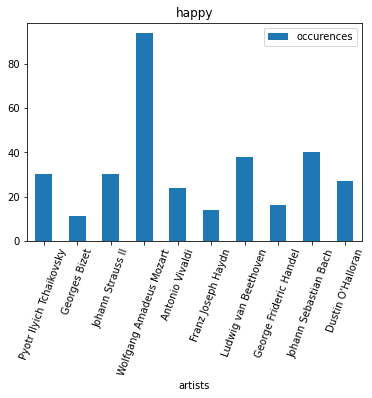

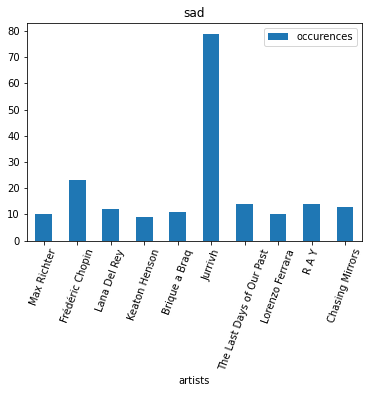

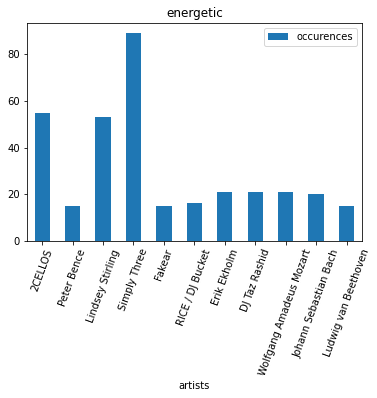

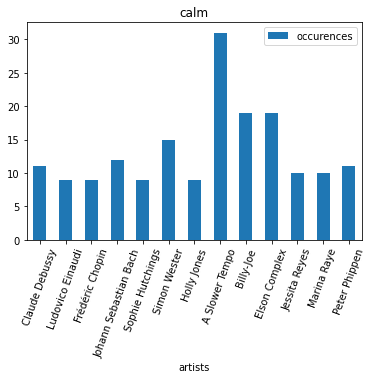

In [30]:
def show_common_artists(song_data, label, n):
    artist_cnt = {}
    for song in song_data:
        artist = song["artist"][0]["name"]
        if artist in artist_cnt:
            artist_cnt[artist] += 1
        else:
            artist_cnt[artist] = 1
            
    cnt = list(artist_cnt.values())
    cnt.sort()
    top_n_val = cnt[-n]
    
    artists = [a for a in artist_cnt.keys() if artist_cnt[a] >= top_n_val]
    cnt = [artist_cnt[a] for a in artist_cnt.keys() if artist_cnt[a] >= top_n_val]
    df = pd.DataFrame(data = {"artists": artists, "occurences": cnt})
    df.plot.bar(x = "artists", y = "occurences", rot = 70, title = label)
    
    return len(artist_cnt.keys())
            
num_diff_artists = {
    "happy": 0,
    "sad": 0,
    "energetic": 0,
    "calm": 0
}

for label in num_diff_artists.keys():
    cnt = show_common_artists(song_data_unique[label], label, 10)
    num_diff_artists[label] = cnt
    
df = pd.DataFrame.from_dict(num_diff_artists, orient = 'index', columns = ['number of different artists'])
df

Za razliku od vokalnih pjesama, koje su vecinom radjene tako da budu pogodne za izvedbu na radiju i slicnim medijima pa obicno imaju krace trajanje, kod instrumentalnih pjesama nemamo neko ocekivanje u pogledu trajanja. Prikazimo to graficki:

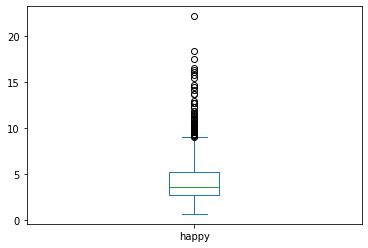

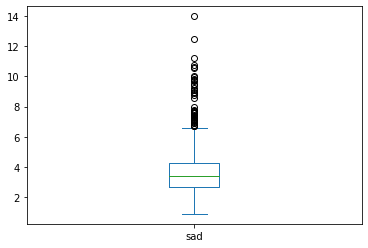

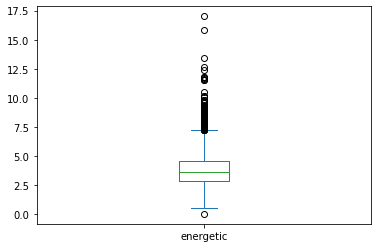

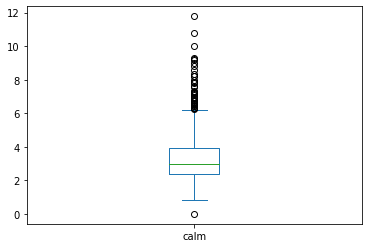

In [31]:
durations = {
    "happy": [],
    "sad": [],
    "energetic": [0],
    "calm": [0]
}

for label in song_data_unique.keys():
    for track in song_data_unique[label]:
        durations[label].append(track["data"][0]["duration_ms"] / 60000.0)

for label in durations:
    df = pd.DataFrame(durations[label], columns = [label])
    df.plot.box()

Pogledajmo i medijane vrijednosti razlicitih atributa:

In [46]:
features = ["danceability", "acousticness", "energy", "instrumentalness", "liveness","valence", "loudness", "speechiness", "tempo"]

mean_vals = []

for label in song_data_unique.keys():
    stats = {}
    vals = []
    for feature in features:
        stats[feature] = []
    for song in song_data_unique[label]:
        for feature in stats.keys():
            stats[feature].append(song["data"][0][feature])
    for feature in features:
        s = stats[feature]
        s.sort()
        half = int(len(s) / 2)
        vals.append(s[half])
    mean_vals += [vals]

df = pd.DataFrame(mean_vals, columns = features, index = song_data_unique.keys())
df

,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo
happy,0.448,0.911,0.2260,0.822,0.112,0.422,-17.121,0.0417,113.456
sad,0.333,0.972,0.1090,0.902,0.107,0.110,-20.287,0.0404,102.010
energetic,0.612,0.145,0.5640,0.833,0.113,0.313,-9.781,0.0449,118.998
calm,0.344,0.989,0.0514,0.920,0.106,0.139,-24.202,0.0436,98.027


Ponovno mozemo vidjeti da je vrijednost atributa 'danceability' najvisa kod pjesama koje su 'energetic', sto je bilo i ocekivano. Zanimljivo je da je vrijednost 'instrumentalness' jako visoka u svim kategorijama, sto smo i ocekivali. Vrijednosti opet nisu normalizirane, sto cemo morati uciniti za sljedecu fazu, a za prvu ruku ih opet normaliziramo uz MinMaxScaler()

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mean_vals)
mean_vals = scaler.transform(mean_vals)
print(mean_vals)

[[0.41218638 0.90758294 0.34061647 0.         0.85714286 1.
  0.49102004 0.28888889 0.73573029]
 [0.         0.97985782 0.11236832 0.81632653 0.14285714 0.
  0.27147909 0.         0.18992895]
 [1.         0.         1.         0.1122449  1.         0.65064103
  1.         1.         1.        ]
 [0.03942652 1.         0.         1.         0.         0.09294872
  0.         0.71111111 0.        ]]


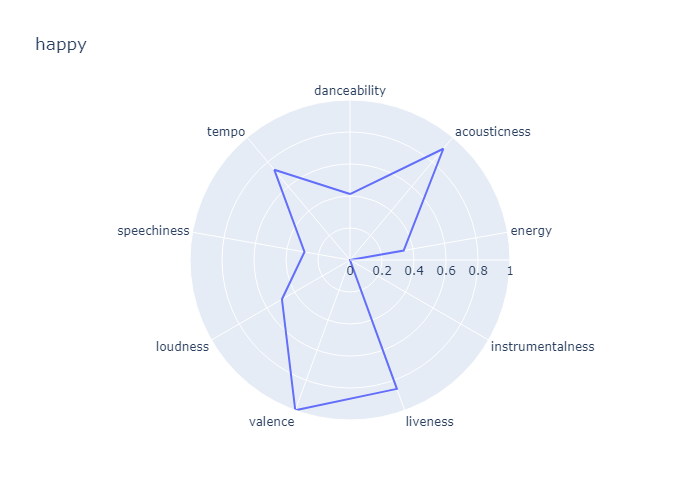

In [48]:
import plotly.express as px

df = pd.DataFrame({"values":mean_vals[0],"Name": features})
fig = px.line_polar(df, r="values", theta='Name', line_close=True, title = "happy")
img_bytes = fig.to_image(format="png")

Image(img_bytes)


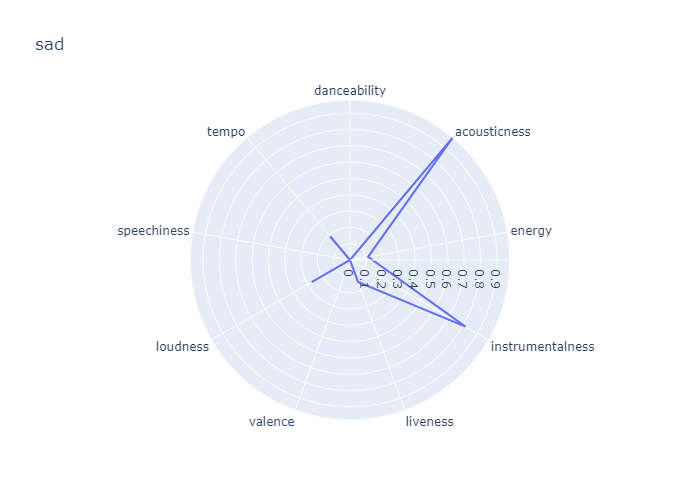

In [49]:
df = pd.DataFrame({"values":mean_vals[1],"Name": features})
fig = px.line_polar(df, r="values", theta='Name', line_close=True, title = "sad")
img_bytes = fig.to_image(format="png")

Image(img_bytes)

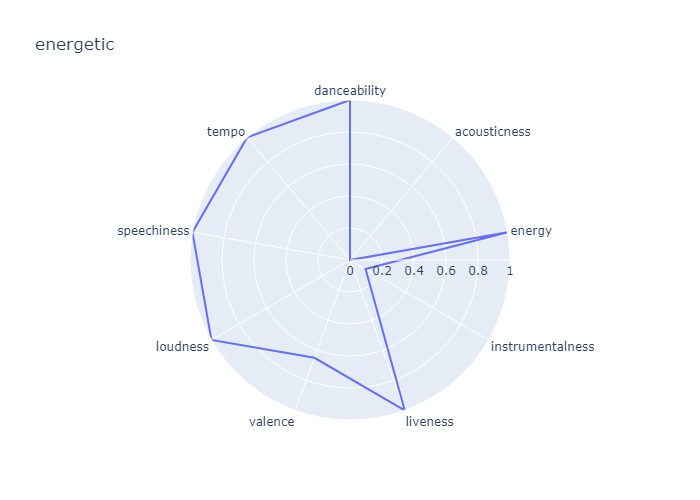

In [50]:
df = pd.DataFrame({"values":mean_vals[2],"Name": features})
fig = px.line_polar(df, r="values", theta='Name', line_close=True, title = "energetic")
img_bytes = fig.to_image(format="png")

Image(img_bytes)

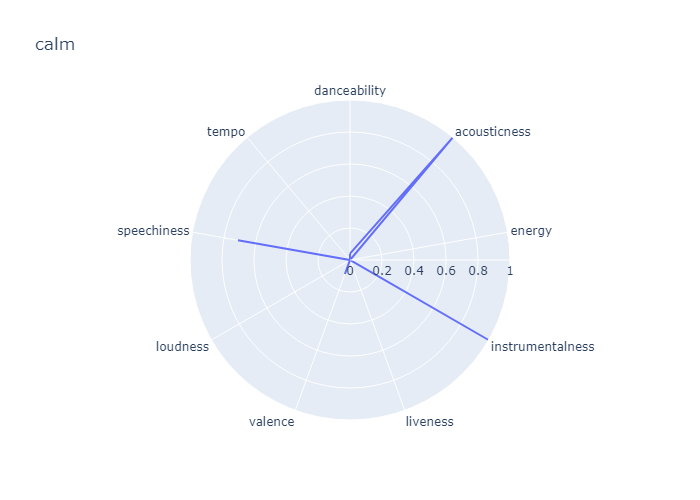

In [51]:
df = pd.DataFrame({"values":mean_vals[3],"Name": features})
fig = px.line_polar(df, r="values", theta='Name', line_close=True, title = "calm")
img_bytes = fig.to_image(format="png")

Image(img_bytes)

### Komentar

Kljucni dio nase analize podataka i pripreme dataseta odradjen je izvan ovog notebooka, a ukljucivao je dobar odabir playlisti, koje smo rucno trazili. Proucavanjem autora playlisti, opisa, komentara, lajkova, hashtagova i sl. smo osigurali veliku raznolikost i dobre datasetove, cime je bilo manje potrebe za programerskom analizom. 
Dodatno, nismo imali velike potrebe za ciscenjem pocetnog dataseta, jer su podaci koje smo dobili kroy Spotify API i biblioteku spotipy bili eksplicitni i jasni, te nije bilo rizika dvoznacnosti, kopija pjesama, razlicitih naziva pjesama, autora itd, koje bi bilo potrebno rjesavati, jer je to odradjeno na razini samog Spotifyja. 